## Trip Lab notebook PREP V12
Prepare dataset with numeric values, boolean values, duration features from dates, and date attributes.
Saturate the outlier y values to +/- 30 minutes. Create one-hot encoded features for some date features.
Reduce one-hot date features. Make date attributes integers. Add dummies for driver_genderlead_org_platform metro names, region names. Add driver had ride ending within 1hr of this ride. Add average seconds late to arrive from prior trips by driver. Add average seconds late to arrive from prior trips to origin location.

Based on what is known before the driver starts driving, predict when the driver will arrive at the pick up location relative to the expected start time. What factors are most predictive of lateness?

In [1]:
import pandas as pd
import numpy as np

In [2]:
dateColNames=['canceled_at_pdt', 'claimed_at_pdt', 'departs_for_trip_at_pdt',
       'created_at_pdt', 'scheduled_starts_at_pdt', 'scheduled_ends_at_pdt',
       'origin_arrived_at_pdt', 'origin_departed_at_pdt',
       'destination_arrived_at_pdt', 'lead_organizer_created_at_pdt',
       'driver_created_at_pdt']

In [3]:
df=pd.read_csv('/Users/bob 2/Projects/TripsData2017.txt', sep='\t', parse_dates=dateColNames)

In [4]:
df.shape

(217348, 74)

In [5]:
list(df)

['id',
 'trip_state',
 'canceled_by',
 'canceled_at_pdt',
 'canceled_before_scheduled_start',
 'claimed_at_pdt',
 'driver_id',
 'lead_organizer_id',
 'creator_id',
 'carpool',
 'is_repeating_ride',
 'shuttle',
 'trip_template_id',
 'departs_for_trip_at_pdt',
 'time_anchor',
 'created_at_pdt',
 'scheduled_starts_at_pdt',
 'scheduled_ends_at_pdt',
 'origin_arrived_at_pdt',
 'origin_departed_at_pdt',
 'destination_arrived_at_pdt',
 'origin_location_id',
 'destination_location_id',
 'origin_region_id',
 'origin_analysis_metro_name',
 'destination_region_id',
 'destination_region_name',
 'origin_region_name',
 'origin_metro_area_name',
 'destination_metro_area_name',
 'destination_analysis_metro_name',
 'origin_lat',
 'origin_lon',
 'destination_lat',
 'destination_lon',
 'passengers_ids',
 'organizers_count',
 'passengers_count',
 'driver_home_lat',
 'driver_home_lon',
 'organizer_home_lat',
 'organizer_home_lon',
 'rating',
 'canceled_by_id',
 'route_legs_count',
 'start_waypoints_zipcode

In [6]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217348 entries, 0 to 217347
Columns: 74 entries, id to driver_has_driven_this_route_before
dtypes: bool(8), datetime64[ns](11), float64(29), int64(5), object(21)
memory usage: 111.1+ MB


In [7]:
df.info

<bound method DataFrame.info of             id trip_state canceled_by     canceled_at_pdt  \
0       367322   canceled    Employee 2017-03-08 13:18:55   
1       492666   canceled    Employee 2017-09-11 09:09:43   
2       527985   canceled    Employee 2017-09-27 14:02:52   
3       415557   canceled    Employee 2017-05-22 13:47:32   
4       317210   canceled    Employee 2017-01-18 10:14:22   
5       338150   complete         NaN                 NaT   
6       310958   complete         NaN                 NaT   
7       338135   complete         NaN                 NaT   
8       324615   complete         NaN                 NaT   
9       247127   complete         NaN                 NaT   
10      306833   complete         NaN                 NaT   
11      436184   complete         NaN                 NaT   
12      473473   complete         NaN                 NaT   
13      354050   complete         NaN                 NaT   
14      415507   complete         NaN                

#### columns_from_the_future must not be used in predictions but some are needed to label the data
exception: those "future" columns from prior trips can be used to predict something about this trip

In [8]:
columns_from_the_future = ['trip_state', 'canceled_by', 'canceled_at_pdt', 'canceled_before_scheduled_start', 'departs_for_trip_at_pdt', 'origin_arrived_at_pdt', 'origin_departed_at_pdt', 'destination_arrived_at_pdt', 'rating', 'trip_paid_time', 'driver_fare_multiplier', 'events', 'has_cd_unclaimed_event', 'is_unfilled_canceled', 'is_cd_cancel', 'canceled_by_id', 'commute_distance', 'predicted_driver_fare_with_multiplier']
print(columns_from_the_future)
print(len(columns_from_the_future))

['trip_state', 'canceled_by', 'canceled_at_pdt', 'canceled_before_scheduled_start', 'departs_for_trip_at_pdt', 'origin_arrived_at_pdt', 'origin_departed_at_pdt', 'destination_arrived_at_pdt', 'rating', 'trip_paid_time', 'driver_fare_multiplier', 'events', 'has_cd_unclaimed_event', 'is_unfilled_canceled', 'is_cd_cancel', 'canceled_by_id', 'commute_distance', 'predicted_driver_fare_with_multiplier']
18


In [9]:
list(df.select_dtypes(['object']).columns)

['trip_state',
 'canceled_by',
 'time_anchor',
 'origin_analysis_metro_name',
 'destination_region_name',
 'origin_region_name',
 'origin_metro_area_name',
 'destination_metro_area_name',
 'destination_analysis_metro_name',
 'passengers_ids',
 'rating',
 'start_waypoints_zipcodes',
 'end_waypoints_zipcodes',
 'lead_organizer_platform',
 'lead_organizer_app_version',
 'driver_platform',
 'driver_app_version',
 'driver_gender',
 'coupon',
 'events',
 'has_cd_unclaimed_event']

In [10]:
df.dtypes

id                                                  int64
trip_state                                         object
canceled_by                                        object
canceled_at_pdt                            datetime64[ns]
canceled_before_scheduled_start                   float64
claimed_at_pdt                             datetime64[ns]
driver_id                                         float64
lead_organizer_id                                   int64
creator_id                                          int64
carpool                                              bool
is_repeating_ride                                    bool
shuttle                                              bool
trip_template_id                                  float64
departs_for_trip_at_pdt                    datetime64[ns]
time_anchor                                        object
created_at_pdt                             datetime64[ns]
scheduled_starts_at_pdt                    datetime64[ns]
scheduled_ends

#### pick or generate features to use as input to prediction.

In [11]:
# compute duration features
durationTuples=[('claimed_before_trip_start_secs', 'claimed_at_pdt', 'scheduled_starts_at_pdt'), 
                ('trip_created_before_trip_start_secs', 'created_at_pdt', 'scheduled_starts_at_pdt'),
                ('trip_est_duration_secs', 'scheduled_starts_at_pdt', 'scheduled_ends_at_pdt'),
                ('org_signup_before_trip_start_secs', 'lead_organizer_created_at_pdt', 'scheduled_starts_at_pdt'),
                ('driver_signup_before_trip_start_secs', 'driver_created_at_pdt', 'scheduled_starts_at_pdt'),
                ('trip_claimed_after_trip_created', 'claimed_at_pdt', 'created_at_pdt'),
                ('driver_signup_before_trip_claimed_secs', 'driver_created_at_pdt', 'claimed_at_pdt'),
                ('org_signup_before_trip_created_secs', 'lead_organizer_created_at_pdt', 'created_at_pdt'),
                ('driver_signup_before_trip_created_secs', 'driver_created_at_pdt', 'created_at_pdt'),
                ('driver_signup_before_org_signup_secs', 'driver_created_at_pdt', 'lead_organizer_created_at_pdt')
                ]

for duration_col_name, from_time, to_time in durationTuples:
    print("creating %s from %s - %s" % (duration_col_name, to_time, from_time))
    df[duration_col_name] = (df[to_time] - df[from_time]).dt.total_seconds()

creating claimed_before_trip_start_secs from scheduled_starts_at_pdt - claimed_at_pdt
creating trip_created_before_trip_start_secs from scheduled_starts_at_pdt - created_at_pdt
creating trip_est_duration_secs from scheduled_ends_at_pdt - scheduled_starts_at_pdt
creating org_signup_before_trip_start_secs from scheduled_starts_at_pdt - lead_organizer_created_at_pdt
creating driver_signup_before_trip_start_secs from scheduled_starts_at_pdt - driver_created_at_pdt
creating trip_claimed_after_trip_created from created_at_pdt - claimed_at_pdt
creating driver_signup_before_trip_claimed_secs from claimed_at_pdt - driver_created_at_pdt
creating org_signup_before_trip_created_secs from created_at_pdt - lead_organizer_created_at_pdt
creating driver_signup_before_trip_created_secs from created_at_pdt - driver_created_at_pdt
creating driver_signup_before_org_signup_secs from lead_organizer_created_at_pdt - driver_created_at_pdt


In [12]:
# compute date attributes
# which dates are not from the future
# make any missing values the lowest number
date_columns_to_process=list(set(df.select_dtypes(include=['datetime64[ns]']).columns) - set(columns_from_the_future))
print(date_columns_to_process)
for col_name in date_columns_to_process:
    print("creating date attributes from %s" % col_name)
    df[col_name + "_quarter"]    = df[col_name].dt.quarter.replace([np.inf, -np.inf, np.nan], 1).astype(int)
    df[col_name + "_month"]      = df[col_name].dt.month.replace([np.inf, -np.inf, np.nan], 1).astype(int)
    df[col_name + "_day"]        = df[col_name].dt.day.replace([np.inf, -np.inf, np.nan], 1).astype(int)
    df[col_name + "_hour"]       = df[col_name].dt.hour.replace([np.inf, -np.inf, np.nan], 1).astype(int)
    df[col_name + "_weekday"]    = df[col_name].dt.weekday.replace([np.inf, -np.inf, np.nan], 0).astype(int)
    df[col_name + "_weekofyear"] = df[col_name].dt.weekofyear.replace([np.inf, -np.inf, np.nan], 1).astype(int)
    df[col_name + "_dayofyear"]  = df[col_name].dt.dayofyear.replace([np.inf, -np.inf, np.nan], 1).astype(int)

['driver_created_at_pdt', 'claimed_at_pdt', 'scheduled_starts_at_pdt', 'lead_organizer_created_at_pdt', 'scheduled_ends_at_pdt', 'created_at_pdt']
creating date attributes from driver_created_at_pdt
creating date attributes from claimed_at_pdt
creating date attributes from scheduled_starts_at_pdt
creating date attributes from lead_organizer_created_at_pdt
creating date attributes from scheduled_ends_at_pdt
creating date attributes from created_at_pdt


In [13]:
# select the date columns to make one-hot columns from
one_hot_source_columns=['scheduled_starts_at_pdt_quarter','scheduled_starts_at_pdt_month',
                        'scheduled_starts_at_pdt_hour','scheduled_starts_at_pdt_weekday',
                        'claimed_at_pdt_quarter','claimed_at_pdt_month',
                        'claimed_at_pdt_hour','claimed_at_pdt_weekday'
                       ]
print(one_hot_source_columns)

['scheduled_starts_at_pdt_quarter', 'scheduled_starts_at_pdt_month', 'scheduled_starts_at_pdt_hour', 'scheduled_starts_at_pdt_weekday', 'claimed_at_pdt_quarter', 'claimed_at_pdt_month', 'claimed_at_pdt_hour', 'claimed_at_pdt_weekday']


In [14]:
# create date one-hot features from those columns
# added drop_first=True to avoid co-linearity
date_dummies = pd.get_dummies(df[one_hot_source_columns],
                              columns=one_hot_source_columns,
                              prefix=one_hot_source_columns,
                              drop_first=True)
date_dummies.head()

,scheduled_starts_at_pdt_quarter_2,scheduled_starts_at_pdt_quarter_3,scheduled_starts_at_pdt_quarter_4,scheduled_starts_at_pdt_month_2,scheduled_starts_at_pdt_month_3,scheduled_starts_at_pdt_month_4,scheduled_starts_at_pdt_month_5,scheduled_starts_at_pdt_month_6,scheduled_starts_at_pdt_month_7,scheduled_starts_at_pdt_month_8,...,claimed_at_pdt_hour_20,claimed_at_pdt_hour_21,claimed_at_pdt_hour_22,claimed_at_pdt_hour_23,claimed_at_pdt_weekday_1,claimed_at_pdt_weekday_2,claimed_at_pdt_weekday_3,claimed_at_pdt_weekday_4,claimed_at_pdt_weekday_5,claimed_at_pdt_weekday_6
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [15]:
date_dummies.columns

Index(['scheduled_starts_at_pdt_quarter_2',
       'scheduled_starts_at_pdt_quarter_3',
       'scheduled_starts_at_pdt_quarter_4', 'scheduled_starts_at_pdt_month_2',
       'scheduled_starts_at_pdt_month_3', 'scheduled_starts_at_pdt_month_4',
       'scheduled_starts_at_pdt_month_5', 'scheduled_starts_at_pdt_month_6',
       'scheduled_starts_at_pdt_month_7', 'scheduled_starts_at_pdt_month_8',
       'scheduled_starts_at_pdt_month_9', 'scheduled_starts_at_pdt_month_10',
       'scheduled_starts_at_pdt_month_11', 'scheduled_starts_at_pdt_month_12',
       'scheduled_starts_at_pdt_hour_1', 'scheduled_starts_at_pdt_hour_2',
       'scheduled_starts_at_pdt_hour_3', 'scheduled_starts_at_pdt_hour_4',
       'scheduled_starts_at_pdt_hour_5', 'scheduled_starts_at_pdt_hour_6',
       'scheduled_starts_at_pdt_hour_7', 'scheduled_starts_at_pdt_hour_8',
       'scheduled_starts_at_pdt_hour_9', 'scheduled_starts_at_pdt_hour_10',
       'scheduled_starts_at_pdt_hour_11', 'scheduled_starts_at_pdt_ho

In [16]:
df = pd.concat([df, date_dummies], axis=1)
df.head()

,id,trip_state,canceled_by,canceled_at_pdt,canceled_before_scheduled_start,claimed_at_pdt,driver_id,lead_organizer_id,creator_id,carpool,...,claimed_at_pdt_hour_20,claimed_at_pdt_hour_21,claimed_at_pdt_hour_22,claimed_at_pdt_hour_23,claimed_at_pdt_weekday_1,claimed_at_pdt_weekday_2,claimed_at_pdt_weekday_3,claimed_at_pdt_weekday_4,claimed_at_pdt_weekday_5,claimed_at_pdt_weekday_6
0,367322,canceled,Employee,2017-03-08 13:18:55,18.68,2017-03-08 13:16:39,62908.0,87303,87303,False,...,0,0,0,0,0,1,0,0,0,0
1,492666,canceled,Employee,2017-09-11 09:09:43,0.84,2017-08-31 12:33:50,62930.0,78527,78527,False,...,0,0,0,0,0,0,1,0,0,0
2,527985,canceled,Employee,2017-09-27 14:02:52,1.07,2017-09-27 13:59:44,62930.0,78527,78527,False,...,0,0,0,0,0,1,0,0,0,0
3,415557,canceled,Employee,2017-05-22 13:47:32,7.47,2017-05-22 13:18:52,62930.0,131139,131139,False,...,0,0,0,0,0,0,0,0,0,0
4,317210,canceled,Employee,2017-01-18 10:14:22,95.76,2017-01-18 10:12:03,62966.0,101326,101326,False,...,0,0,0,0,0,1,0,0,0,0


In [17]:
# create contextual feature relating trip to preceeding complete trip by same driver (similar to back-to-back rides)
# A little training bias here: keeping only complete trips uses trip_state of current trip which is unknown at the time.
df_driver_start_order = df[['id', 'trip_state', 'driver_id', 'scheduled_starts_at_pdt', 'scheduled_ends_at_pdt']][df['trip_state']=='complete'].sort_values(by=['driver_id', 'scheduled_starts_at_pdt'])
# df_driver_start_order.head(20)
# assign back this to a column and see that it sets the right values
df_driver_start_order['drivers_prev_ride_1hr']=np.logical_and(
    ( df_driver_start_order['driver_id'] == df_driver_start_order['driver_id'].shift(1) ), 
    ( df_driver_start_order['scheduled_starts_at_pdt'] - df_driver_start_order['scheduled_ends_at_pdt'].shift(1) ) < np.timedelta64(1, 'h')
)
# df_driver_start_order.head(20)
# copy boolean value back to working dataframe df
df['drivers_prev_ride_1hr']=df_driver_start_order['drivers_prev_ride_1hr']
# fill in with False for canceled trips
df.drivers_prev_ride_1hr.fillna(False, inplace=True) 
df[['id', 'trip_state', 'driver_id', 'scheduled_starts_at_pdt', 'scheduled_ends_at_pdt', 'drivers_prev_ride_1hr']][df['driver_id']==62969].sort_values(by=['driver_id', 'scheduled_starts_at_pdt']).head(20)

,id,trip_state,driver_id,scheduled_starts_at_pdt,scheduled_ends_at_pdt,drivers_prev_ride_1hr
163321,296204,complete,62969.0,2017-01-04 07:40:00,2017-01-04 08:12:00,False
122589,298079,complete,62969.0,2017-01-04 14:10:00,2017-01-04 15:32:33,False
149859,298794,canceled,62969.0,2017-01-05 16:10:00,2017-01-05 16:42:00,False
109082,299268,complete,62969.0,2017-01-06 15:00:00,2017-01-06 15:41:09,False
54758,294286,complete,62969.0,2017-01-09 07:40:00,2017-01-09 08:00:44,False
68331,267173,complete,62969.0,2017-01-09 15:15:00,2017-01-09 15:40:05,False
68333,297978,complete,62969.0,2017-01-09 16:30:00,2017-01-09 17:04:00,True
149862,301256,complete,62969.0,2017-01-10 07:00:00,2017-01-10 07:38:58,False
149860,294830,complete,62969.0,2017-01-10 15:00:00,2017-01-10 15:29:51,False
163322,300995,complete,62969.0,2017-01-10 16:20:00,2017-01-10 16:39:05,True


In [18]:
# create another contextual feature: driver average seconds late to arrive from prior trips
# the hypothesis here is that how late the driver was to prior trips will help predict how late she will be to this trip
# use 10 prior trips not including this observation

##y=(df.loc[df['origin_arrived_at_pdt'].notnull()].origin_arrived_at_pdt 
##   - df.loc[df['origin_arrived_at_pdt'].notnull()].scheduled_starts_at_pdt).dt.total_seconds().clip(-1800,1800)

# find the columns with an arrived time and sort them by driver and arrived time
df_driver_arrived_order = df[['id', 'trip_state', 'driver_id', 'scheduled_starts_at_pdt', 'origin_arrived_at_pdt']] \
    [df['origin_arrived_at_pdt'].notnull()] \
        .sort_values(by=['driver_id', 'origin_arrived_at_pdt'])
# create a counter to rank each trip for each driver
df_driver_arrived_order['trip_counter'] = df_driver_arrived_order.groupby('driver_id')['id'].cumcount()+1
# compute how many seconds late the driver arrived (negaive if arrived early) and clip to +/- 30 minutes
df_driver_arrived_order['arrived_late_seconds'] = \
    (df_driver_arrived_order['origin_arrived_at_pdt'] - \
       df_driver_arrived_order['scheduled_starts_at_pdt']) \
    .dt.total_seconds().clip(-1800,1800).astype(int)
# sum up the rolling lateness over 11 trips, 10 prior trips and the current one
df_driver_arrived_order['sum11_arrived_late_seconds'] = \
    df_driver_arrived_order.groupby('driver_id')['arrived_late_seconds'] \
       .rolling(11,min_periods=1).sum().reset_index(0,drop=True)
## logic is: avg = prior sum / number of prior trips
## prior sum = cumsum - current trip value; 
## number of prior trips = tripcount-1 clipped to 10 since max is 10 prior values
## the first trip in a series will get NaN since we divide by 0, but that is replaced with mean value over all trips
df_driver_arrived_order['avg_prior_arrived_late_seconds'] = \
    ( (df_driver_arrived_order.sum11_arrived_late_seconds \
       - df_driver_arrived_order.arrived_late_seconds) \
      / (df_driver_arrived_order['trip_counter']-1).clip(upper=10) ) \
    .fillna((df_driver_arrived_order['arrived_late_seconds'].mean())).astype(int)

##df_driver_arrived_order.head(20)
# copy value back to working dataframe df
df['avg_prior_arrived_late_seconds']=df_driver_arrived_order['avg_prior_arrived_late_seconds']
# trip with no arrival time will not get this avg written back
df[['id', 'trip_state', 'driver_id', 'scheduled_starts_at_pdt', 'origin_arrived_at_pdt', 'avg_prior_arrived_late_seconds']][df['driver_id']==62969].sort_values(by=['driver_id', 'origin_arrived_at_pdt']).head(20)



,id,trip_state,driver_id,scheduled_starts_at_pdt,origin_arrived_at_pdt,avg_prior_arrived_late_seconds
163321,296204,complete,62969.0,2017-01-04 07:40:00,2017-01-04 07:35:24,-415.0
122589,298079,complete,62969.0,2017-01-04 14:10:00,2017-01-04 14:09:28,-276.0
109082,299268,complete,62969.0,2017-01-06 15:00:00,2017-01-06 14:53:39,-154.0
54758,294286,complete,62969.0,2017-01-09 07:40:00,2017-01-09 07:36:27,-229.0
68331,267173,complete,62969.0,2017-01-09 15:15:00,2017-01-09 15:10:46,-225.0
68333,297978,complete,62969.0,2017-01-09 16:30:00,2017-01-09 16:18:26,-231.0
149862,301256,complete,62969.0,2017-01-10 07:00:00,2017-01-10 06:58:34,-308.0
149860,294830,complete,62969.0,2017-01-10 15:00:00,2017-01-10 14:53:59,-276.0
163322,300995,complete,62969.0,2017-01-10 16:20:00,2017-01-10 16:18:50,-287.0
40964,294288,complete,62969.0,2017-01-11 07:40:00,2017-01-11 07:33:43,-263.0


In [19]:
# create another contextual feature: origin location average seconds late to arrive from prior trips
# the hypothesis here is that how late any driver was to this origin location on prior trips will help predict how late this driver will be to this trip
# use 10 prior trips not including this observation

# find the columns with an arrived time and sort them by origin_location_id and arrived time
df_origin_location_arrived_order = df[['id', 'trip_state', 'origin_location_id', 'scheduled_starts_at_pdt', 'origin_arrived_at_pdt']] \
    [df['origin_arrived_at_pdt'].notnull()] \
        .sort_values(by=['origin_location_id', 'origin_arrived_at_pdt'])
# create a counter to rank each trip for each origin location
df_origin_location_arrived_order['trip_counter'] = df_origin_location_arrived_order.groupby('origin_location_id')['id'].cumcount()+1
# compute how many seconds late any driver arrived to each trip (negaive if arrived early) and clip to +/- 30 minutes
df_origin_location_arrived_order['arrived_late_seconds'] = \
    (df_origin_location_arrived_order['origin_arrived_at_pdt'] - \
       df_origin_location_arrived_order['scheduled_starts_at_pdt']) \
    .dt.total_seconds().clip(-1800,1800).astype(int)
# sum up the rolling lateness over 11 trips to this origin location, 10 prior trips and the current one
df_origin_location_arrived_order['sum11_arrived_late_seconds'] = \
    df_origin_location_arrived_order.groupby('origin_location_id')['arrived_late_seconds'] \
       .rolling(11,min_periods=1).sum().reset_index(0,drop=True)
## logic is: avg = prior sum / number of prior trips
## prior sum = cumsum - current trip value; 
## number of prior trips = tripcount-1 clipped to 10 since max is 10 prior values
## the first trip in a series will get NaN since we divide by 0, but that is replaced with mean value over all trips
df_origin_location_arrived_order['avg_prior_arrived_late_seconds_to_origin_location'] = \
    ( (df_origin_location_arrived_order.sum11_arrived_late_seconds \
       - df_origin_location_arrived_order.arrived_late_seconds) \
      / (df_origin_location_arrived_order['trip_counter']-1).clip(upper=10) ) \
    .fillna((df_origin_location_arrived_order['arrived_late_seconds'].mean())).astype(int)

##df_origin_location_arrived_order.head(20)
# copy value back to working dataframe df
df['avg_prior_arrived_late_seconds_to_origin_location']=df_origin_location_arrived_order['avg_prior_arrived_late_seconds_to_origin_location']
# trip with no arrival time will not get this avg written back; thats OK, those trips not used in training or test set
df[['id', 'trip_state', 'origin_location_id', 'scheduled_starts_at_pdt', 'origin_arrived_at_pdt', 'avg_prior_arrived_late_seconds_to_origin_location']][df['driver_id']==62969].sort_values(by=['origin_location_id', 'origin_arrived_at_pdt']).head(20)



,id,trip_state,origin_location_id,scheduled_starts_at_pdt,origin_arrived_at_pdt,avg_prior_arrived_late_seconds_to_origin_location
122584,367935,complete,53633.0,2017-03-10 17:00:00,2017-03-10 16:48:44,-721.0
109072,352843,canceled,81556.0,2017-02-24 15:05:00,NaT,NaN
149858,354700,complete,81603.0,2017-02-27 14:45:00,2017-02-27 14:32:30,-284.0
27345,303965,complete,81644.0,2017-01-12 16:10:00,2017-01-12 16:08:12,-475.0
149859,298794,canceled,81644.0,2017-01-05 16:10:00,NaT,NaN
54751,358877,complete,81830.0,2017-03-16 15:25:00,2017-03-16 15:21:42,-309.0
163318,341687,complete,81944.0,2017-02-24 16:15:00,2017-02-24 16:06:58,-493.0
190360,341692,complete,81944.0,2017-03-03 16:15:00,2017-03-03 16:12:03,-388.0
203740,341697,complete,81944.0,2017-03-10 16:15:00,2017-03-10 16:16:48,-306.0
27346,324277,canceled,81944.0,2017-02-17 16:15:00,NaT,NaN


In [20]:
# select misc columns to make one-hot columns from
misc_one_hot_source_columns=['driver_gender','lead_organizer_platform',
                             'origin_analysis_metro_name','origin_region_name'
                            ]
print(misc_one_hot_source_columns)

['driver_gender', 'lead_organizer_platform', 'origin_analysis_metro_name', 'origin_region_name']


In [21]:
# create misc one-hot features from those columns
# added drop_first=True to avoid co-linearity
misc_dummies = pd.get_dummies(df[misc_one_hot_source_columns],
                              columns=misc_one_hot_source_columns,
                              prefix=misc_one_hot_source_columns,
                              drop_first=True)
misc_dummies.head()

,driver_gender_male,lead_organizer_platform_ios,lead_organizer_platform_web,origin_analysis_metro_name_Default (Unassigned),origin_analysis_metro_name_LA,origin_analysis_metro_name_OC,origin_region_name_Central LA - South,origin_region_name_Central LA - West,origin_region_name_Default (Unassigned),origin_region_name_East Bay North,...,origin_region_name_San Gabriel Valley - West,origin_region_name_San Jose,origin_region_name_Santa Clarita,origin_region_name_South Bay,origin_region_name_South LA,origin_region_name_Southeast LA,origin_region_name_Tri Valley,origin_region_name_Ventura,origin_region_name_Westside,origin_region_name_antelope-valley
0,1,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
misc_dummies.columns

Index(['driver_gender_male', 'lead_organizer_platform_ios',
       'lead_organizer_platform_web',
       'origin_analysis_metro_name_Default (Unassigned)',
       'origin_analysis_metro_name_LA', 'origin_analysis_metro_name_OC',
       'origin_region_name_Central LA - South',
       'origin_region_name_Central LA - West',
       'origin_region_name_Default (Unassigned)',
       'origin_region_name_East Bay North',
       'origin_region_name_East Bay South',
       'origin_region_name_East Contra Costa', 'origin_region_name_Eastside',
       'origin_region_name_Inland Empire',
       'origin_region_name_Lamorinda Walnut Creek',
       'origin_region_name_Long Beach', 'origin_region_name_Malibu',
       'origin_region_name_North Bay', 'origin_region_name_Oakland Berkeley',
       'origin_region_name_Orange County - Central',
       'origin_region_name_Orange County - North',
       'origin_region_name_Orange County - South',
       'origin_region_name_Orange County - West',
       'origi

In [23]:
df = pd.concat([df, misc_dummies], axis=1)
df.head()

,id,trip_state,canceled_by,canceled_at_pdt,canceled_before_scheduled_start,claimed_at_pdt,driver_id,lead_organizer_id,creator_id,carpool,...,origin_region_name_San Gabriel Valley - West,origin_region_name_San Jose,origin_region_name_Santa Clarita,origin_region_name_South Bay,origin_region_name_South LA,origin_region_name_Southeast LA,origin_region_name_Tri Valley,origin_region_name_Ventura,origin_region_name_Westside,origin_region_name_antelope-valley
0,367322,canceled,Employee,2017-03-08 13:18:55,18.68,2017-03-08 13:16:39,62908.0,87303,87303,False,...,0,0,0,0,0,0,0,0,0,0
1,492666,canceled,Employee,2017-09-11 09:09:43,0.84,2017-08-31 12:33:50,62930.0,78527,78527,False,...,0,0,0,0,0,0,0,0,0,0
2,527985,canceled,Employee,2017-09-27 14:02:52,1.07,2017-09-27 13:59:44,62930.0,78527,78527,False,...,0,0,0,0,0,0,0,0,0,0
3,415557,canceled,Employee,2017-05-22 13:47:32,7.47,2017-05-22 13:18:52,62930.0,131139,131139,False,...,0,0,0,0,0,0,0,0,0,0
4,317210,canceled,Employee,2017-01-18 10:14:22,95.76,2017-01-18 10:12:03,62966.0,101326,101326,False,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# confirm added more features
df.shape

(217348, 256)

In [25]:
df.dtypes

id                                                        int64
trip_state                                               object
canceled_by                                              object
canceled_at_pdt                                  datetime64[ns]
canceled_before_scheduled_start                         float64
claimed_at_pdt                                   datetime64[ns]
driver_id                                               float64
lead_organizer_id                                         int64
creator_id                                                int64
carpool                                                    bool
is_repeating_ride                                          bool
shuttle                                                    bool
trip_template_id                                        float64
departs_for_trip_at_pdt                          datetime64[ns]
time_anchor                                              object
created_at_pdt                          

In [26]:
# which booleans are not from the future
bool_columns_to_convert=list(set(df.select_dtypes(include=['bool']).columns) - set(columns_from_the_future))
print(bool_columns_to_convert)

['is_repeating_ride', 'is_same_day_ride', 'is_affiliate', 'carpool', 'drivers_prev_ride_1hr', 'shuttle', 'driver_has_driven_this_route_before']


In [27]:
##df[bool_columns_to_convert].astype(int).head()
bool_columns_as_int_names=[s + "_int" for s in bool_columns_to_convert]
# create new int columns containing 1,0 from bool columns which are True,False
df[bool_columns_as_int_names] = df[bool_columns_to_convert].astype(int)
df[bool_columns_as_int_names].head()

,is_repeating_ride_int,is_same_day_ride_int,is_affiliate_int,carpool_int,drivers_prev_ride_1hr_int,shuttle_int,driver_has_driven_this_route_before_int
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0


In [28]:
feature_columns_to_use=list(set(df.select_dtypes(include=['number']).columns) - set(columns_from_the_future))
print(feature_columns_to_use)

['claimed_at_pdt_hour_22', 'claimed_at_pdt_hour_1', 'scheduled_starts_at_pdt_hour_11', 'origin_analysis_metro_name_OC', 'scheduled_starts_at_pdt_quarter', 'created_at_pdt_weekofyear', 'origin_region_id', 'claimed_at_pdt_month_4', 'origin_region_name_San Fernando Valley - East', 'lead_organizer_created_at_pdt_month', 'scheduled_starts_at_pdt_month_5', 'scheduled_starts_at_pdt_hour_5', 'scheduled_starts_at_pdt_weekday', 'origin_region_name_Southeast LA', 'claimed_at_pdt_hour_2', 'passengers_count', 'origin_region_name_East Contra Costa', 'destination_lat', 'origin_region_name_Lamorinda Walnut Creek', 'driver_home_lat', 'scheduled_starts_at_pdt_month_12', 'avg_prior_arrived_late_seconds_to_origin_location', 'origin_region_name_Peninsula South', 'driver_signup_before_trip_claimed_secs', 'scheduled_starts_at_pdt_weekday_2', 'origin_lat', 'organizer_home_lat', 'origin_region_name_antelope-valley', 'created_at_pdt_hour', 'origin_region_name_Inland Empire', 'created_at_pdt_dayofyear', 'origin_

#### compute arrived_late label, ah should be 5 min late. At 0 seconds, 9% of trips are "late"!

In [29]:
# note this is just for testing, the real calc is below see "materialize the prediction target"
arrival_time_df=df[['id','scheduled_starts_at_pdt','origin_arrived_at_pdt']]
arrival_time_df.shape
arrival_time_df=arrival_time_df.assign(
    arrived_seconds_after_scheduled_start=lambda x:
        (x['origin_arrived_at_pdt'] - x['scheduled_starts_at_pdt']).dt.total_seconds().clip(-1800,1800)
)

# show number of nulls
arrival_time_df.isnull().sum()



id                                           0
scheduled_starts_at_pdt                      0
origin_arrived_at_pdt                    91673
arrived_seconds_after_scheduled_start    91673
dtype: int64

In [30]:
arrival_time_df.dropna().shape


(125675, 4)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11bb2bbe0>]],
      dtype=object)

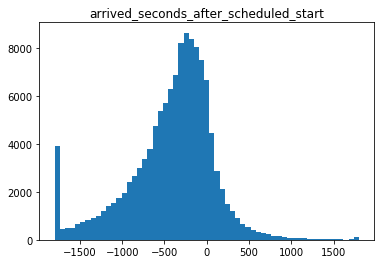

In [32]:
arrival_time_df.dropna().hist(column='arrived_seconds_after_scheduled_start',bins=np.linspace(-1800,1800,60),grid=False)


In [33]:
# arrives 7 minutes early on average partially due to saturation
arrival_time_df[['arrived_seconds_after_scheduled_start']].dropna().mean()/60

arrived_seconds_after_scheduled_start   -6.93286
dtype: float64

In [34]:
# most often arrives 30 minutes early because of saturation!
arrival_time_df[['arrived_seconds_after_scheduled_start']].dropna().mode()/60

,arrived_seconds_after_scheduled_start
0,-30.0


In [35]:
# show rows and label to verify logic
# arrived_late_df[arrived_late_df['label']].head # version where label is TRUE
arrival_time_df.head(20)

,id,scheduled_starts_at_pdt,origin_arrived_at_pdt,arrived_seconds_after_scheduled_start
0,367322,2017-03-09 08:00:00,NaT,NaN
1,492666,2017-09-11 10:00:00,NaT,NaN
2,527985,2017-09-27 15:07:00,NaT,NaN
3,415557,2017-05-22 21:16:00,NaT,NaN
4,317210,2017-01-22 10:00:00,NaT,NaN
5,338150,2017-02-14 16:00:00,2017-02-14 15:51:43,-497.0
6,310958,2017-01-24 16:20:00,2017-01-24 16:20:05,5.0
7,338135,2017-02-08 16:00:00,2017-02-08 15:54:47,-313.0
8,324615,2017-01-26 16:30:00,2017-01-26 16:25:04,-296.0
9,247127,2017-01-23 14:45:00,2017-01-23 14:42:14,-166.0


In [36]:
# features look ok, contain some NaNs
df[feature_columns_to_use].head()

,claimed_at_pdt_hour_22,claimed_at_pdt_hour_1,scheduled_starts_at_pdt_hour_11,origin_analysis_metro_name_OC,scheduled_starts_at_pdt_quarter,created_at_pdt_weekofyear,origin_region_id,claimed_at_pdt_month_4,origin_region_name_San Fernando Valley - East,lead_organizer_created_at_pdt_month,...,total_predicted_duration,scheduled_starts_at_pdt_hour_9,claimed_at_pdt_quarter_4,origin_location_id,claimed_at_pdt_hour_3,drivers_prev_ride_1hr_int,driver_home_lon,scheduled_starts_at_pdt_hour,origin_lon,driver_signup_before_org_signup_secs
0,0,0,0,0,1,10,25.0,0,0,7,...,13.75,0,0,119715.0,0,0,-118.27,8,-95.36,-66670.0
1,0,0,0,0,3,35,33.0,0,0,7,...,6.72,0,0,52933.0,0,0,-118.34,10,-118.27,-70303.0
2,0,0,0,0,3,39,33.0,0,0,7,...,4.67,0,0,81534.0,0,0,-118.34,15,-118.27,-70303.0
3,0,0,0,0,2,21,36.0,0,0,2,...,18.90,0,0,118697.0,0,0,-118.34,21,-118.30,20301220.0
4,0,0,0,0,1,3,36.0,0,0,7,...,15.82,0,0,97313.0,0,0,-118.27,10,-118.29,1293532.0


In [37]:
# hmmm too many NaNs
df[feature_columns_to_use].dropna().shape

(49, 216)

In [38]:
# replace NaNs with 0s, although another solution for missing latlons is probably better
df[feature_columns_to_use].fillna(0).shape

(217348, 216)

In [39]:
# eliminate rows where on-time arrival cannot be computed (canceled before arrival, possibly filled).
df.loc[df['origin_arrived_at_pdt'].notnull()].shape

(125675, 263)

In [40]:
# how many observations of each final state do we have left where on-time arrival can be labeled
df.loc[df['origin_arrived_at_pdt'].notnull()].groupby(['trip_state']).size()

trip_state
canceled      1529
complete    124146
dtype: int64

In [41]:
# how many are filled; all should be but 1 wierd trip arrived with no driver! 
# chaotic race condition when scheduled start time approaching, cancel by organizer, removing driver, and driver arriving 
# It will be filled with 0 which is ok.
df.loc[df['origin_arrived_at_pdt'].notnull()].groupby(['trip_state',df.driver_id.notnull()]).size()

trip_state  driver_id
canceled    False             1
            True           1528
complete    True         124146
dtype: int64

In [42]:
# materialize the useful dataset for training and testing
df_X=df.loc[df['origin_arrived_at_pdt'].notnull()][feature_columns_to_use].fillna(0)
df_X.shape

(125675, 216)

In [43]:
# materialize the prediction target (arrived_seconds_after_scheduled_start)
y=(df.loc[df['origin_arrived_at_pdt'].notnull()].origin_arrived_at_pdt 
   - df.loc[df['origin_arrived_at_pdt'].notnull()].scheduled_starts_at_pdt).dt.total_seconds().clip(-1800,1800)

# describe and convert from scientific notation
y.describe().apply(lambda x: '%.0f' % x)

count    125675
mean       -416
std         509
min       -1800
25%        -657
50%        -324
75%         -96
max        1800
dtype: object

In [44]:
# write out features (df_X) and targets (y) into files
fileprefix='./lateness_PREP_V12_'
df_X.to_csv(fileprefix+'X.csv', sep='\t')


In [45]:
y.to_csv(path=fileprefix+'y.csv', sep='\t')

In [46]:
y.shape

(125675,)

In [47]:
y.head()

5   -497.0
6      5.0
7   -313.0
8   -296.0
9   -166.0
dtype: float64